<a href="https://colab.research.google.com/github/boomyun713/114_homework/blob/main/W4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
stock_id = '2454.tw'
end = dt.date.today()
start = dt.datetime(2022, 1, 1)
end = dt.datetime(2025, 10, 1)

stock_data = yf.download(stock_id, start=start, end=end).reset_index()

stock_data["Date"] = pd.to_datetime(stock_data["Date"])
stock_data.set_index("Date", inplace=True)
print(stock_data.head())

/tmp/ipython-input-3354235864.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_id, start=start, end=end).reset_index()
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open   Volume
Ticker         2454.TW     2454.TW     2454.TW     2454.TW  2454.TW
Date                                                               
2022-01-03  864.915039  913.801541  861.154539  906.280541  7374387
2022-01-04  876.196777  883.717780  861.154773  876.196777  6688764
2022-01-05  883.717712  894.999215  864.915208  879.957211  7020406
2022-01-06  853.633667  868.675670  834.831163  864.915169  8129690
2022-01-07  827.310181  861.154688  819.789179  849.873186  8258414


In [5]:
close_prices = stock_data[['Volume']]

In [6]:
train_size = int(len(close_prices) * 0.8)
train_data = close_prices[:train_size]
test_data = close_prices[train_size:]

In [7]:
print('訓練集形狀：', train_data.shape)
print('測試集形狀：', test_data.shape)

訓練集形狀： (726, 1)
測試集形狀： (182, 1)


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [12]:
import numpy as np
window_size = 10
def create_dataset(dataset, window_size):

    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(y)
X_train, y_train = create_dataset(train_data_scaled, window_size)
X_test, y_test = create_dataset(test_data_scaled, window_size)
print(f"\n滑動窗口處理後:")
print(f"X_train 原始形狀: {X_train.shape}")
print(f"y_train 形狀: {y_train.shape}")
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(f"X_train 重塑後形狀: {X_train.shape}")
print(f"X_test 重塑後形狀: {X_test.shape}")


滑動窗口處理後:
X_train 原始形狀: (716, 10)
y_train 形狀: (716,)
X_train 重塑後形狀: (716, 10, 1)
X_test 重塑後形狀: (172, 10, 1)


In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(716, 10, 1) (716,) (172, 10, 1) (172,)


In [17]:
import tensorflow as tf
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):

    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):

    window_size = 10
    n_outputs = 1
    n_features = 1
    inputs = tf.keras.Input(shape=(window_size, n_features), name='Input')
    x = inputs

    for _ in range(num_trans_blocks):
        x = transformer_encoder(
            x,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            attention_axes=attention_axes,
            kernel_size=kernel_size,
            epsilon=epsilon
        )
    x = layers.GlobalAveragePooling1D(data_format='channels_first')(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation='relu')(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs, name='one-step_prediction_transformer_encoder_model')

In [18]:
transformer_model = build_transfromer(
    head_size=128,
    num_heads=4,
    ff_dim=2,
    num_trans_blocks=4,
    mlp_units=[256],
    mlp_dropout=0.10,
    dropout=0.10,
    attention_axes=1
)

transformer_model.compile(optimizer='adam', loss='mse')
transformer_model.summary()

Model: "one-step_prediction_transformer_encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 10, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 1)     │          2 │ Input[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 1)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 2)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 1)     │          3 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 1)     │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 1)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10, 2)     │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 10, 1)     │          3 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 1)     │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_3[0][0]     

 Total params: 17,457 (68.19 KB)

 Trainable params: 17,457 (68.19 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
hist = transformer_model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0212 - val_loss: 0.0106
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0135 - val_loss: 0.0080
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0127 - val_loss: 0.0075
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0115 - val_loss: 0.0078
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0107 - val_loss: 0.0069
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0110 - val_loss: 0.0070
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0108 - val_loss: 0.0070
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0103 - val_loss: 0.0070
Epoch 9/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0112 - val_loss: 0.0073
Epoch 10/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0096 - val_loss: 0.0070
Epoch 11/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0113 - val_loss: 0.0072
Epoch 12/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0

In [21]:
mse = transformer_model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0134
Mean Squared Error: 0.01241726242005825


In [22]:
y_pred = transformer_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
test_predict = pd.DataFrame(
    y_pred, columns=['Predicted'], index=test_data[window_size:].index)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step


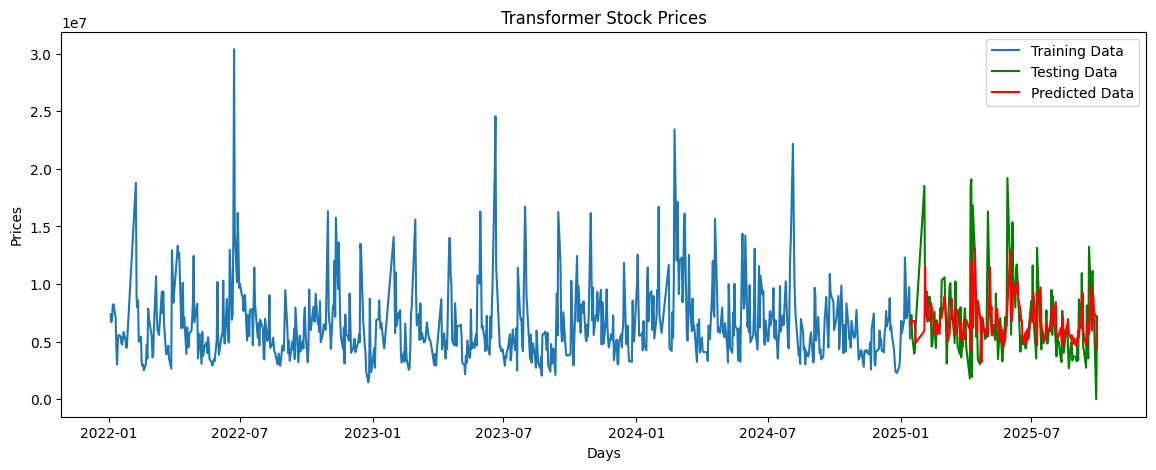

In [23]:
plt.figure(figsize=(14, 5))
plt.plot(close_prices[:train_size + window_size],
         label='Training Data')
plt.plot(close_prices[train_size + window_size:],
         label='Testing Data', color='green')
plt.plot(test_predict, label='Predicted Data', color='red')
plt.title('Transformer Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [24]:
import numpy as np

window_size = 20
n_outputs = 20

print(f"輸入窗口大小: {window_size} 天")
print(f"預測步數: {n_outputs} 天")

def create_dataset(dataset, window_size, n_outputs):

    X, y = [], []
    for i in range(len(dataset) - window_size - n_outputs + 1):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size:i + window_size + n_outputs, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data_scaled, window_size, n_outputs)
X_test, y_test = create_dataset(test_data_scaled, window_size, n_outputs)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

輸入窗口大小: 20 天
預測步數: 20 天


In [25]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(687, 20, 1) (687, 20) (143, 20, 1) (143, 20)


In [28]:
import tensorflow as tf
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):


    x = layers.LayerNormalization(epsilon=epsilon)(inputs)

    x = layers.MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
    window_size, n_outputs, n_features = 20, 20, 1

    inputs = tf.keras.Input(shape=(window_size, n_features), name='Input')
    x = inputs

    for _ in range(num_trans_blocks):
        x = transformer_encoder(
            x,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            attention_axes=attention_axes,
            kernel_size=kernel_size,
            epsilon=epsilon
        )

    x = layers.GlobalAveragePooling1D(data_format='channels_first')(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation='relu')(x)
        x = layers.Dropout(mlp_dropout)(x)


    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs, name='multi-step_prediction_transformer_encoder_model')

In [29]:
transformer_model = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
transformer_model.compile(optimizer='adam', loss='mse')
transformer_model.summary()

Model: "multi-step_prediction_transformer_encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 20, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ Input[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 20, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 20, 1)     │          0 │ dropout_14[0][0], │
│                     │                   │            │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 20, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 20, 2)     │          0 │ conv1d_8[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 20, 1)     │          3 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 20, 1)     │          0 │ conv1d_9[0][0],   │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 20, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 20, 1)     │          0 │ dropout_17[0][0], │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 20, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 20, 2)     │          0 │ conv1d_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 20, 1)     │          3 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 24,900 (97.27 KB)

 Trainable params: 24,900 (97.27 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
hist = transformer_model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - loss: 0.0362 - val_loss: 0.0126
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0180 - val_loss: 0.0115
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0167 - val_loss: 0.0109
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0140 - val_loss: 0.0107
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0143 - val_loss: 0.0104
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0141 - val_loss: 0.0104
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0144 - val_loss: 0.0103
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0130 - val_loss: 0.0102
Epoch 9/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0138 - val_loss: 0.0103
Epoch 10/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0129 - val_loss: 0.0102
Epoch 11/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0134 - val_loss: 0.0102
Epoch 12/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 

In [31]:
mse = transformer_model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0145
Mean Squared Error: 0.013109198771417141


In [32]:
y_pred = transformer_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
test_true = scaler.inverse_transform(y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


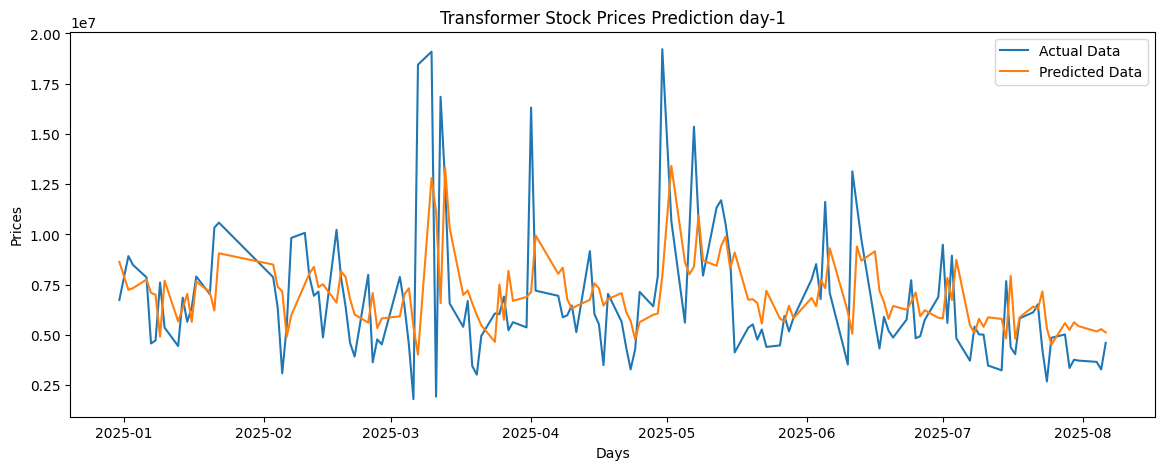

Day 1 MSE: 9188725484392.307



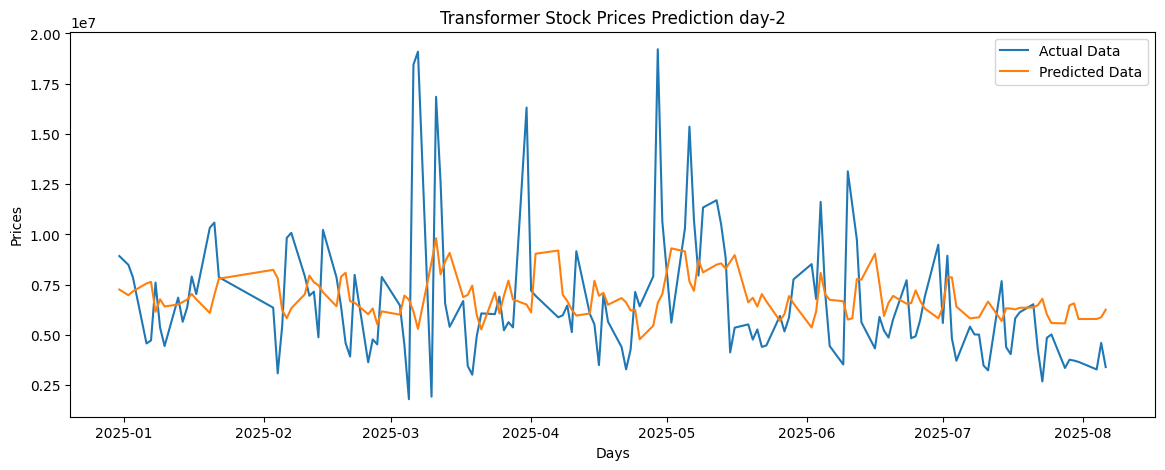

Day 2 MSE: 10780267751059.152



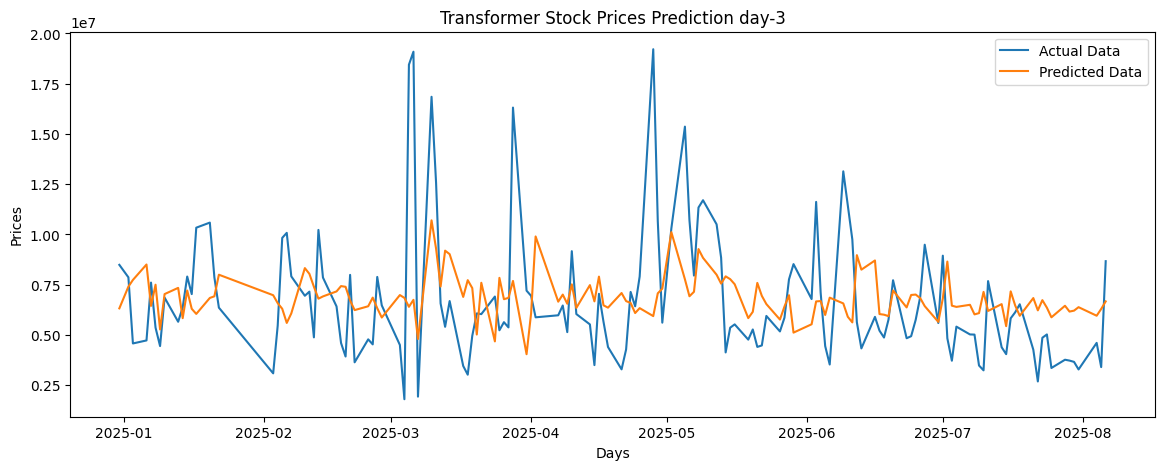

Day 3 MSE: 10255889805470.104



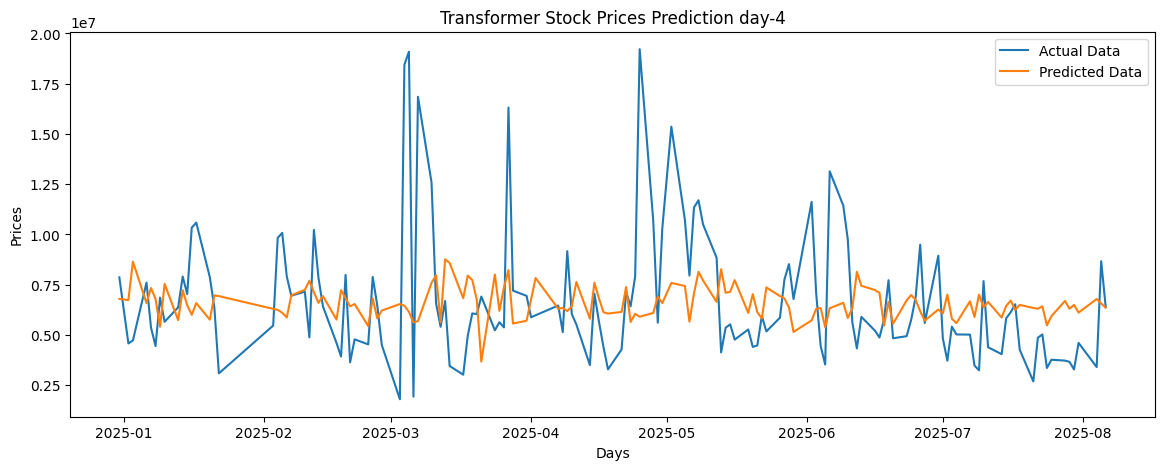

Day 4 MSE: 10896236502336.38



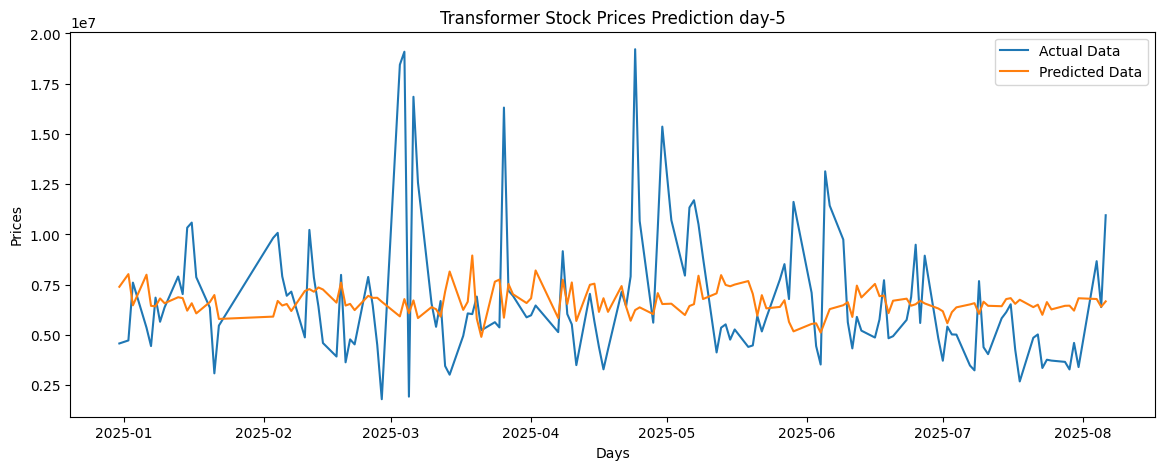

Day 5 MSE: 11349842018335.252



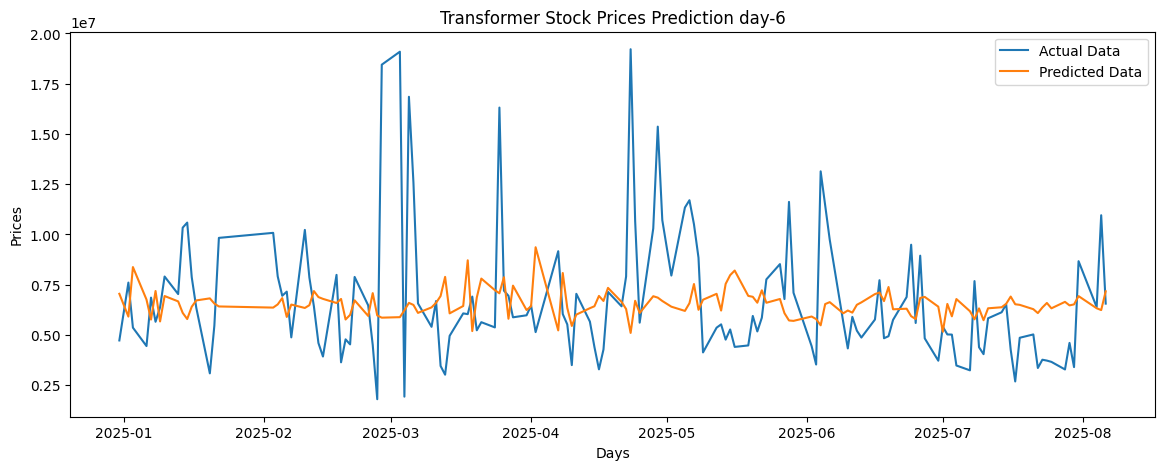

Day 6 MSE: 11654374521517.404



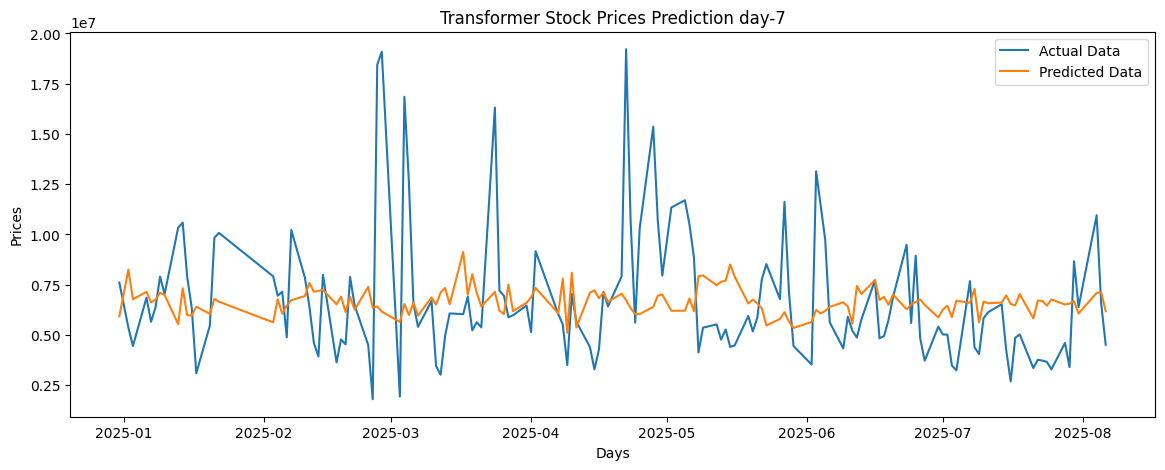

Day 7 MSE: 11222423577954.928



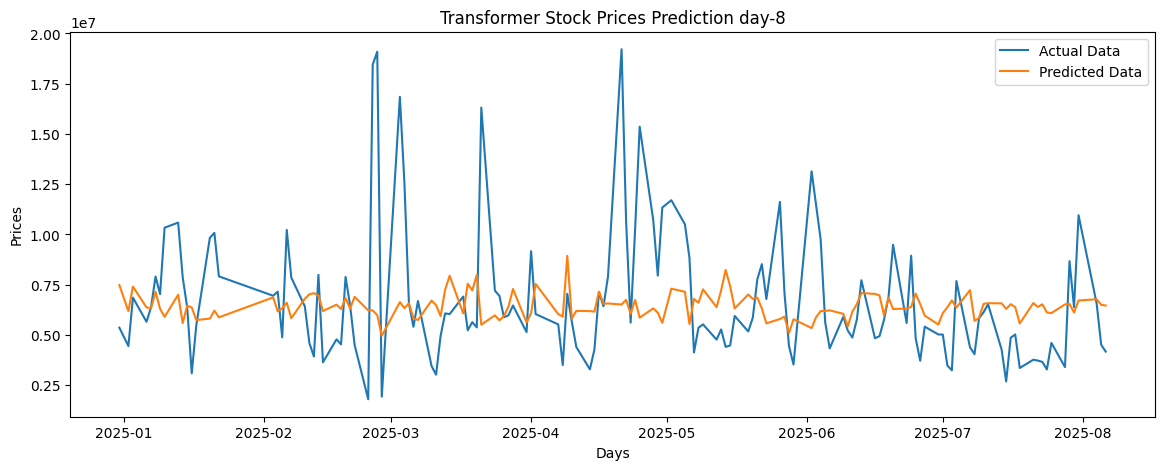

Day 8 MSE: 11228486672569.791



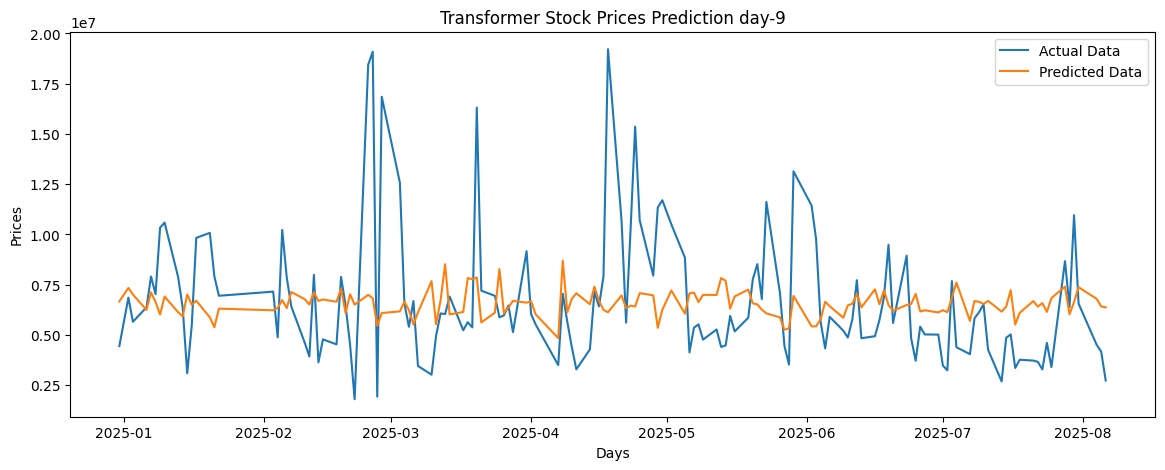

Day 9 MSE: 10899009272166.158



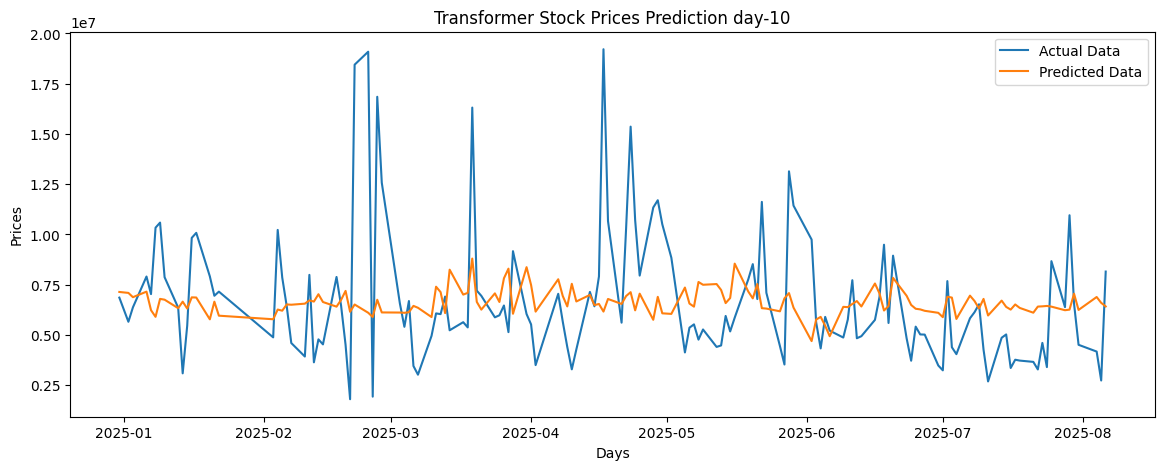

Day 10 MSE: 10834093274174.812



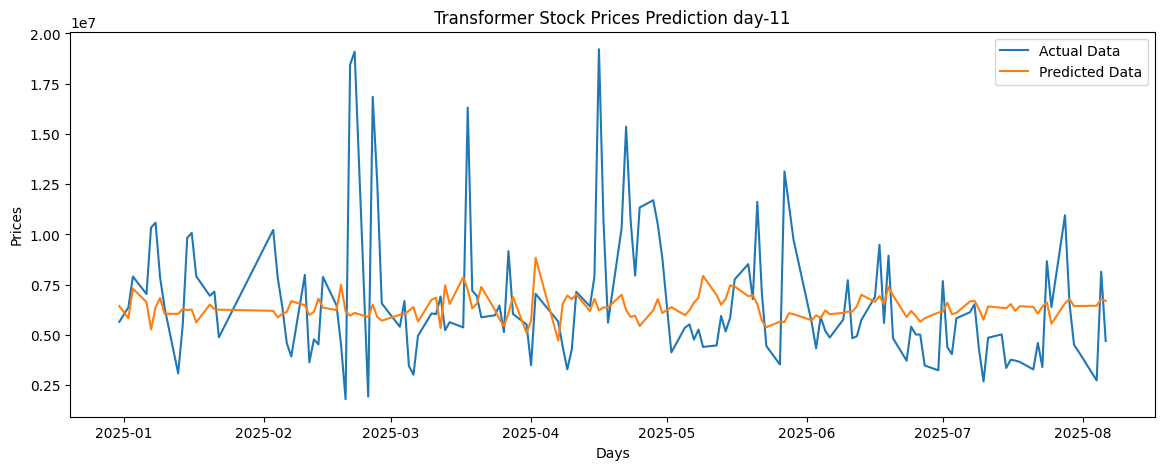

Day 11 MSE: 11004009648049.258



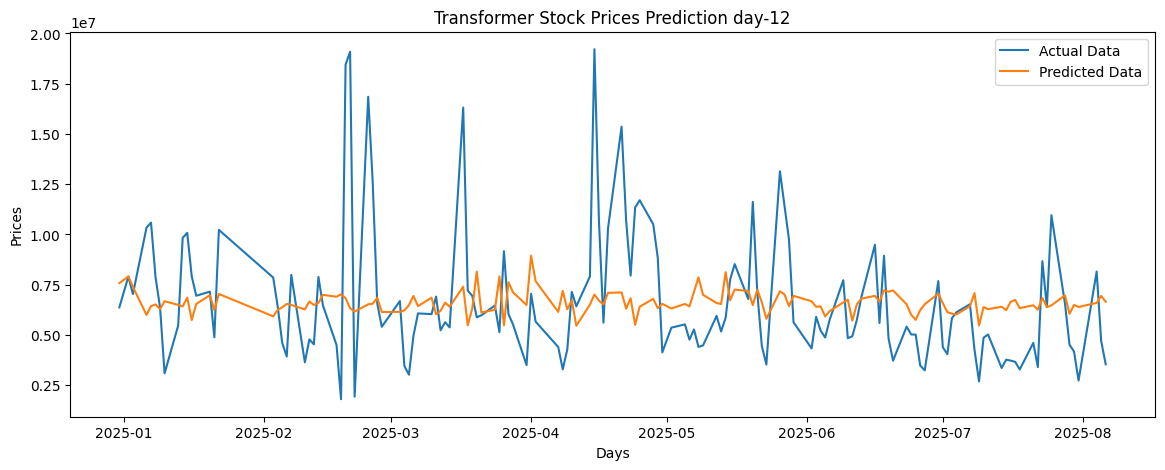

Day 12 MSE: 10518532163793.72



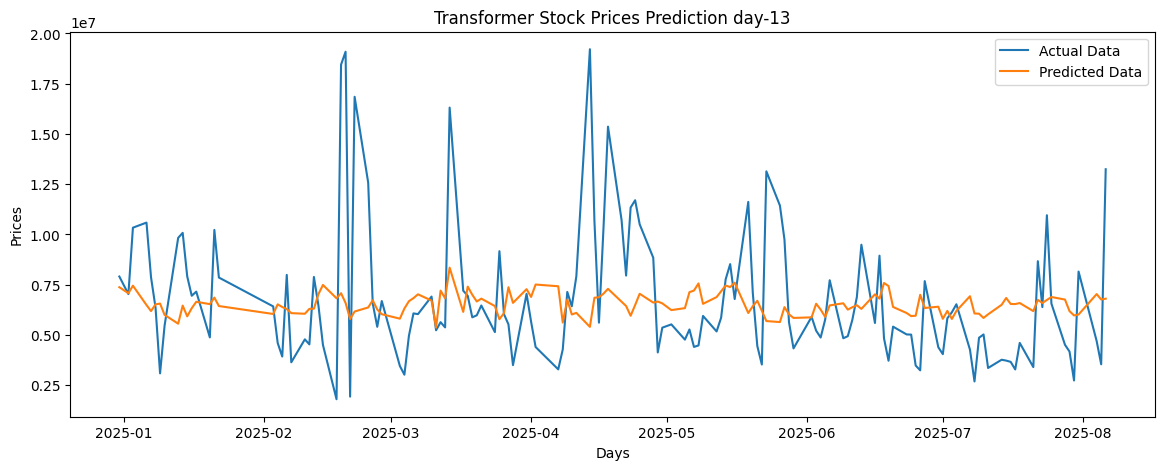

Day 13 MSE: 11036548298094.025



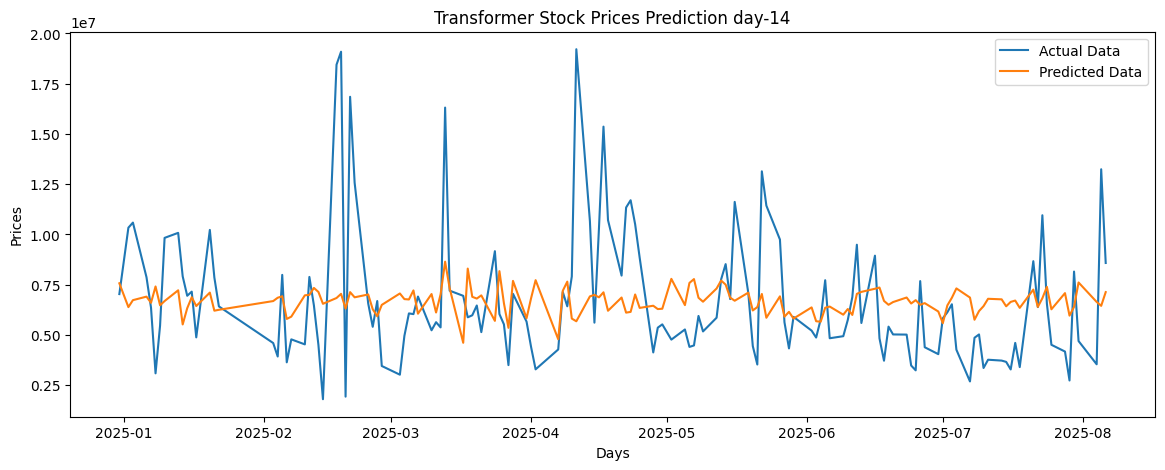

Day 14 MSE: 10853733710689.91



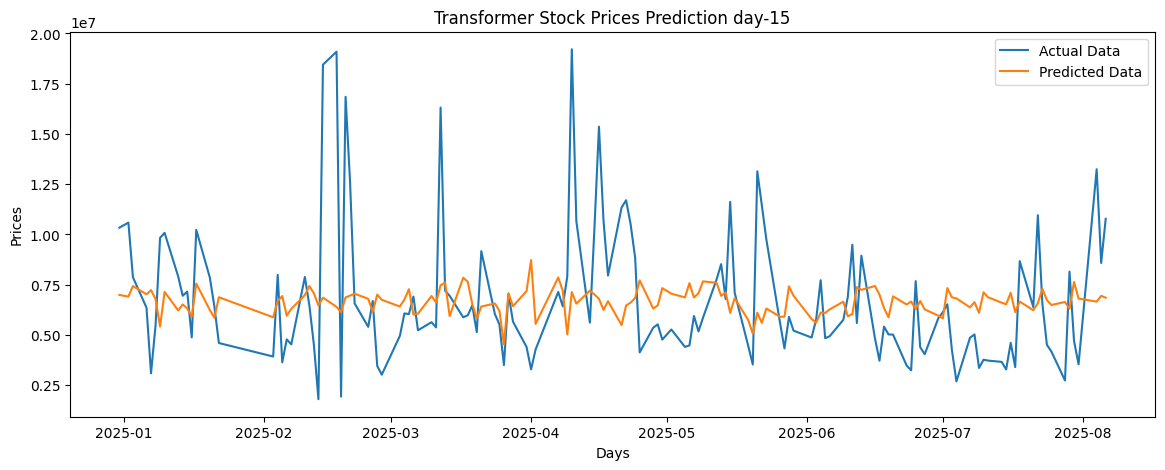

Day 15 MSE: 11308824554893.658



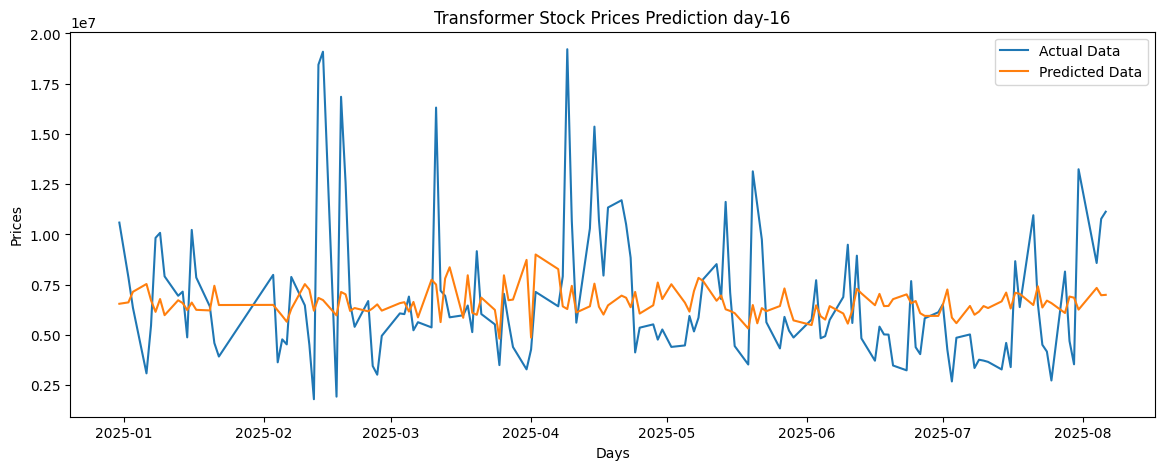

Day 16 MSE: 11044682014227.531



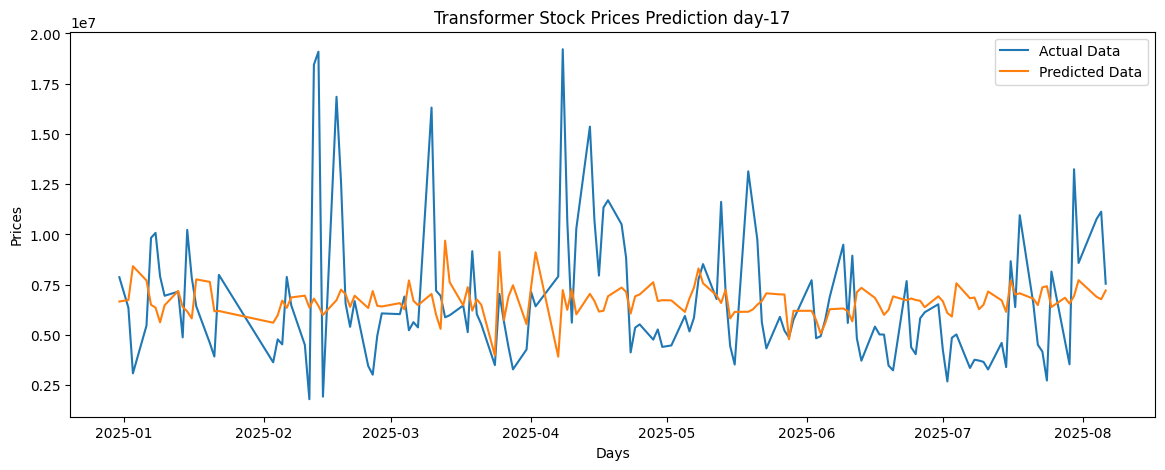

Day 17 MSE: 11354354976088.27



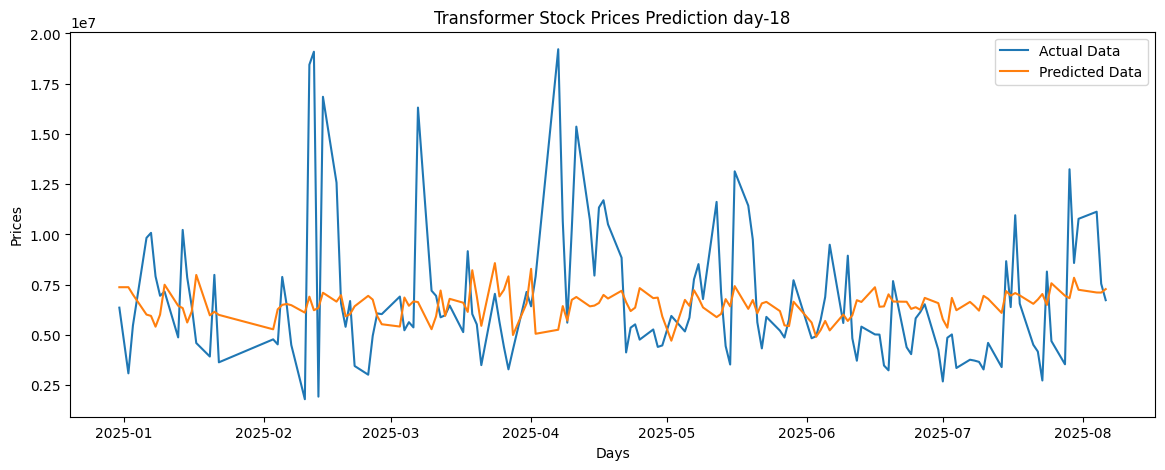

Day 18 MSE: 11346958733472.047



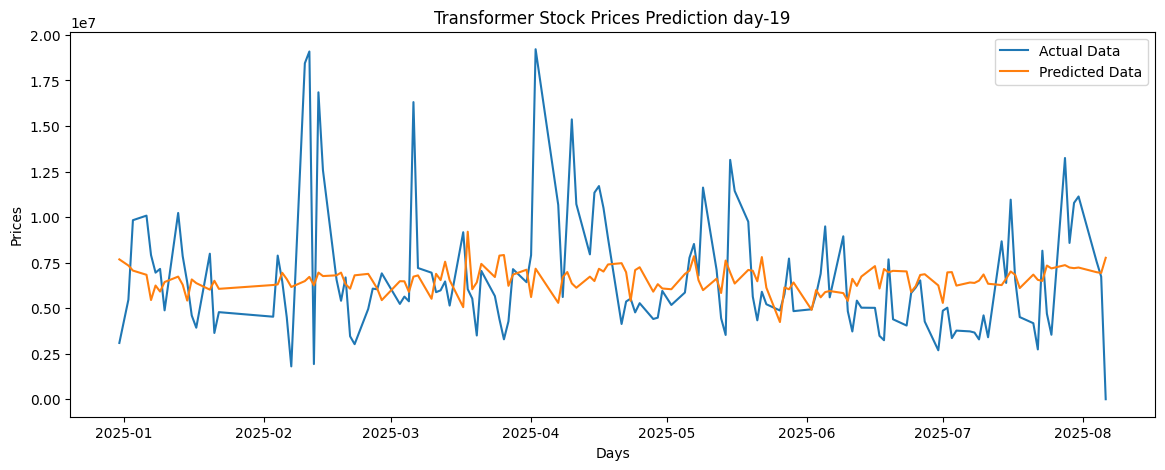

Day 19 MSE: 11560044612794.328



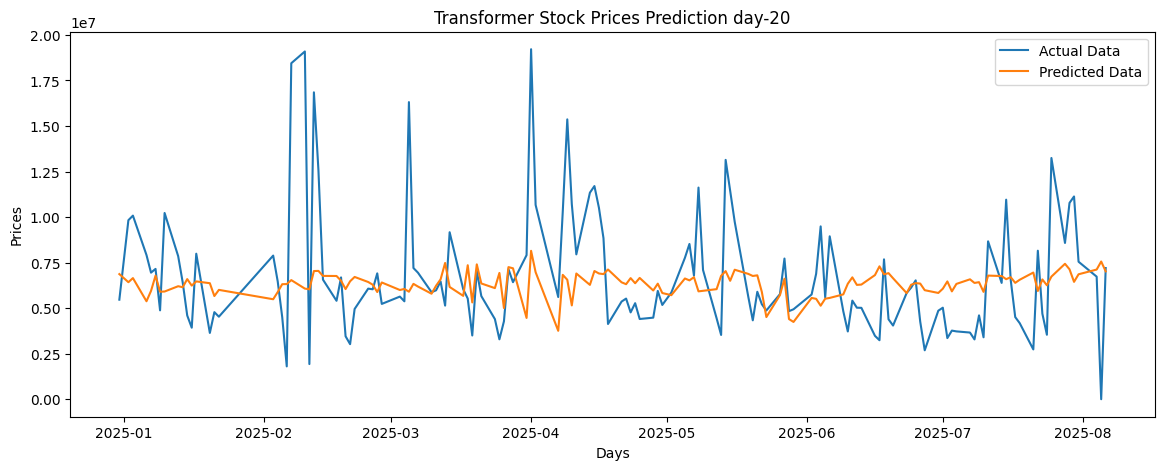

Day 20 MSE: 11081447914998.008



In [34]:
from sklearn.metrics import mean_squared_error
for i in range(n_outputs):
    plt.figure(figsize=(14, 5))
    test_true_df = pd.DataFrame(
        test_true[:, i], columns=['Actual'], index=test_data.index[:len(test_true)])
    test_predict_df = pd.DataFrame(
        y_pred[:, i], columns=['Predicted'], index=test_data.index[:len(y_pred)])
    plt.plot(test_true_df, label='Actual Data')
    plt.plot(test_predict_df, label='Predicted Data')
    plt.title(f'Transformer Stock Prices Prediction day-{i + 1}')
    plt.xlabel('Days')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()
    mse = mean_squared_error(test_true[:, i], y_pred[:, i])
    print(f'Day {i + 1} MSE:', mse)
    print()